In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np

In [3]:
import jetset
print('tested on jetset',jetset.__version__)

tested on jetset 1.3.0rc7


Depending parameters
====================

In the following we show how to link parameters in the same model or among different models, and how to make a paramter depending on other parameters according to a mathematical expression. 

## Example: linked paramters for EBL

In [4]:
from jetset.jet_model import Jet
from jetset.template_2Dmodel import EBLAbsorptionTemplate
from jetset.model_manager import FitModel

my_jet = Jet(electron_distribution='lppl', name='jet_flaring')
my_jet.parameters.z_cosm.val = 0.01

ebl_franceschini = EBLAbsorptionTemplate.from_name('Franceschini_2008')

composite_model = FitModel(nu_size=500, name='EBL corrected')
composite_model.add_component(my_jet)
composite_model.add_component(ebl_franceschini)

composite_model.show_pars()

composite_model.link_par(par_name='z_cosm', from_model='Franceschini_2008', to_model='jet_flaring')
v=0.03001
my_jet.parameters.z_cosm.val = v
assert (composite_model.Franceschini_2008.parameters.z_cosm.val==v)
assert (composite_model.Franceschini_2008.parameters.z_cosm.linked==True)

composite_model.composite_expr = '%s*%s'%(my_jet.name,ebl_franceschini.name)
composite_model.eval()

#if plot is True:
#    composite_model.plot_model()

composite_model.save_model('ebl_jet.pkl')
new_composite_model=FitModel.load_model('ebl_jet.pkl')
new_composite_model.show_pars()
v=2.0
new_composite_model.jet_flaring.parameters.z_cosm.val=v
print('new_composite_model.Franceschini_2008.parameters.z_cosm.val',new_composite_model.Franceschini_2008.parameters.z_cosm.val,'v',v)
assert (new_composite_model.Franceschini_2008.parameters.z_cosm.val == v)
assert (new_composite_model.Franceschini_2008.parameters.z_cosm.linked == True)

===> setting C threads to 12


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_flaring,R,region_size,cm,5.000000e+15,1.000000e+03,1.000000e+30,False,False
jet_flaring,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_flaring,B,magnetic_field,gauss,1.000000e-01,0.000000e+00,--,False,False
jet_flaring,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e+00,0.000000e+00,--,False,True
jet_flaring,beam_obj,beaming,,1.000000e+01,1.000000e-04,--,False,False
jet_flaring,z_cosm,redshift,,1.000000e-02,0.000000e+00,--,False,False
jet_flaring,gmin,low-energy-cut-off,lorentz-factor*,2.000000e+00,1.000000e+00,1.000000e+09,False,False
jet_flaring,gmax,high-energy-cut-off,lorentz-factor*,1.000000e+06,1.000000e+00,1.000000e+15,False,False
jet_flaring,N,emitters_density,1 / cm3,1.000000e+02,0.000000e+00,--,False,False
jet_flaring,gamma0_log_parab,turn-over-energy,lorentz-factor*,1.000000e+04,1.000000e+00,1.000000e+09,False,False


adding par: z_cosm to  z_cosm
===> setting C threads to 12
adding par: z_cosm to  z_cosm


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_flaring,gmin,low-energy-cut-off,lorentz-factor*,2.000000e+00,1.000000e+00,1.000000e+09,False,False
jet_flaring,gmax,high-energy-cut-off,lorentz-factor*,1.000000e+06,1.000000e+00,1.000000e+15,False,False
jet_flaring,N,emitters_density,1 / cm3,1.000000e+02,0.000000e+00,--,False,False
jet_flaring,gamma0_log_parab,turn-over-energy,lorentz-factor*,1.000000e+04,1.000000e+00,1.000000e+09,False,False
jet_flaring,s,LE_spectral_slope,,2.000000e+00,-1.000000e+01,1.000000e+01,False,False
jet_flaring,r,spectral_curvature,,4.000000e-01,-1.500000e+01,1.500000e+01,False,False
jet_flaring,R,region_size,cm,5.000000e+15,1.000000e+03,1.000000e+30,False,False
jet_flaring,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_flaring,B,magnetic_field,gauss,1.000000e-01,0.000000e+00,--,False,False
jet_flaring,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e+00,0.000000e+00,--,False,True


new_composite_model.Franceschini_2008.parameters.z_cosm.val 2.0 v 2.0


## Example: depending pars for bkn power-law emitters

here we create a custom `bkn` distribution where we impose a functional dependence among the low and high-energy spectral index.

In [5]:
from jetset.jet_emitters import EmittersDistribution
import numpy as np



from jetset.jet_model import Jet

j = Jet(emitters_distribution='bkn')


j.parameters


===> setting C threads to 12


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,5.000000e+15,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,1.000000e-01,0.000000e+00,--,False,False
jet_leptonic,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e+00,0.000000e+00,--,False,True
jet_leptonic,beam_obj,beaming,,1.000000e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,1.000000e-01,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,2.000000e+00,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.000000e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,1.000000e+02,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,1.000000e+04,1.000000e+00,1.000000e+09,False,False


None

the functional dependence can be provided by a python function, where the argument (`p` in this case) is the same name as the parameter:

In [6]:
def f_p(p):
    return p+1
j.make_dependent_par(par='p_1',depends_on=['p'],par_expr=f_p)
j.parameters.p.val=2
np.testing.assert_allclose(j.parameters.p_1.val, j.parameters.p.val + 1)
j.parameters

adding par: p to  p_1
==> par p_1 is depending on ['p'] according to expr:   p_1 =
def f_p(p):
    return p+1



model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,5.000000e+15,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,1.000000e-01,0.000000e+00,--,False,False
jet_leptonic,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e+00,0.000000e+00,--,False,True
jet_leptonic,beam_obj,beaming,,1.000000e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,1.000000e-01,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,2.000000e+00,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.000000e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,1.000000e+02,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,1.000000e+04,1.000000e+00,1.000000e+09,False,False


None

as you can notice, now a message is shown describing the dependence of the parameters 

It is also possible to set the dependence function as a string that can be evaluated

In [7]:
j.make_dependent_par(par='p_1',depends_on=['p'],par_expr='p+1')
j.parameters.p.val=2
np.testing.assert_allclose(j.parameters.p_1.val, j.parameters.p.val + 1)
j.parameters

==> par p_1 is depending on ['p'] according to expr:   p_1 =
p+1


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,5.000000e+15,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,1.000000e-01,0.000000e+00,--,False,False
jet_leptonic,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e+00,0.000000e+00,--,False,True
jet_leptonic,beam_obj,beaming,,1.000000e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,1.000000e-01,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,2.000000e+00,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.000000e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,1.000000e+02,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,1.000000e+04,1.000000e+00,1.000000e+09,False,False


None

In principle, you can use strings for short expressions, and functions for more complicated formulas.

You can print the actual expression/function for the depending parameter using the `print_par_expr` method:

In [8]:
#j.parameters.p_1.par_expression_source_code

In [9]:
j.save_model('jet.pkl')
new_jet=Jet.load_model('jet.pkl')


===> setting C threads to 12
adding par: p to  p_1
==> par p_1 is depending on ['p'] according to expr:   p_1 =
p+1


In [10]:
new_jet.parameters.p.val=2.5
np.testing.assert_allclose(new_jet.parameters.p_1.val, new_jet.parameters.p.val + 1)
new_jet.parameters

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,2.000000e+00,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.000000e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,1.000000e+02,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,1.000000e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p(M),LE_spectral_slope,,2.500000e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,"*p_1(D,p)",HE_spectral_slope,,3.500000e+00,-1.000000e+01,1.000000e+01,False,True
jet_leptonic,R,region_size,cm,5.000000e+15,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,1.000000e-01,0.000000e+00,--,False,False
jet_leptonic,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e+00,0.000000e+00,--,False,True


None

## Example depending par: Building a Jet model with B function of R_H and R_0

In this example we create a fuctional dependence among the paramters `B`, `R_H` introducing user custom pararameters. Wewant that  the value of the mangentic field in the jet is a function or `R_H`, and  of the initial value of `B=B0` at `R=R_H0`, according to the expression: 

$B=B_0(R_0/R_H)^{1.1}$

In [11]:
jet=Jet(emitters_distribution='plc')
fit_model_lsb=FitModel( jet=jet, name='SSC-best-fit-lsb',template=None)
fit_model_lsb.jet_leptonic.parameters.beam_obj.fit_range = [5, 50]
fit_model_lsb.jet_leptonic.parameters.R_H.val=5E17
fit_model_lsb.jet_leptonic.parameters.R_H.frozen=False
fit_model_lsb.jet_leptonic.parameters.R_H.fit_range = [1E15, 1E19]
fit_model_lsb.jet_leptonic.parameters.R.fit_range = [10 ** 15.5, 10 ** 17.5]

fit_model_lsb.jet_leptonic.add_user_par(name='B0',units='G',val=1E3,val_min=0,val_max=None)
fit_model_lsb.jet_leptonic.add_user_par(name='R0', units='cm', val=5E13, val_min=0, val_max=None)
fit_model_lsb.jet_leptonic.add_user_par(name='m_B', val=1, val_min=1, val_max=2)
fit_model_lsb.jet_leptonic.parameters.R0.frozen=True
fit_model_lsb.jet_leptonic.parameters.B0.frozen=True

def par_func(R0,B0,R_H,m_B): 
    return B0*np.power((R0/R_H),m_B)

fit_model_lsb.jet_leptonic.make_dependent_par(par='B', depends_on=['B0', 'R0', 'R_H','m_B'], par_expr=par_func)

B0=fit_model_lsb.jet_leptonic.parameters.B0.val
R0 = fit_model_lsb.jet_leptonic.parameters.R0.val
R_H = fit_model_lsb.jet_leptonic.parameters.R_H.val
m_B= fit_model_lsb.jet_leptonic.parameters.m_B.val

np.testing.assert_allclose(fit_model_lsb.jet_leptonic.parameters.B.val, par_func(R0,B0,R_H,m_B))

===> setting C threads to 12
adding par: B0 to  B
adding par: R0 to  B
adding par: R_H to  B
adding par: m_B to  B
==> par B is depending on ['B0', 'R0', 'R_H', 'm_B'] according to expr:   B =
def par_func(R0,B0,R_H,m_B): 
    return B0*np.power((R0/R_H),m_B)



In [12]:

fit_model_lsb.jet_leptonic.parameters

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,5.000000e+15,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H(M),region_position,cm,5.000000e+17,0.000000e+00,--,False,False
jet_leptonic,"*B(D,m_B)",magnetic_field,gauss,1.000000e-01,0.000000e+00,--,False,True
jet_leptonic,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e+00,0.000000e+00,--,False,True
jet_leptonic,beam_obj,beaming,,1.000000e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,1.000000e-01,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,2.000000e+00,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.000000e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,1.000000e+02,0.000000e+00,--,False,False
jet_leptonic,gamma_cut,turn-over-energy,lorentz-factor*,1.000000e+04,1.000000e+00,1.000000e+09,False,False


None

In [13]:
fit_model_lsb.jet_leptonic.parameters

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,5.000000e+15,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H(M),region_position,cm,5.000000e+17,0.000000e+00,--,False,False
jet_leptonic,"*B(D,m_B)",magnetic_field,gauss,1.000000e-01,0.000000e+00,--,False,True
jet_leptonic,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e+00,0.000000e+00,--,False,True
jet_leptonic,beam_obj,beaming,,1.000000e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,1.000000e-01,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,2.000000e+00,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.000000e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,1.000000e+02,0.000000e+00,--,False,False
jet_leptonic,gamma_cut,turn-over-energy,lorentz-factor*,1.000000e+04,1.000000e+00,1.000000e+09,False,False


None

In [14]:
fit_model_lsb.save_model('test.pkl')

In [15]:
fit_model_lsb=FitModel.load_model('test.pkl')

===> setting C threads to 12
adding par: B0 to  B
adding par: R0 to  B
adding par: R_H to  B
adding par: m_B to  B
==> par B is depending on ['B0', 'R0', 'R_H', 'm_B'] according to expr:   B =
def par_func(R0,B0,R_H,m_B): 
    return B0*np.power((R0/R_H),m_B)



In [16]:
B0=fit_model_lsb.jet_leptonic.parameters.B0.val
R0 = fit_model_lsb.jet_leptonic.parameters.R0.val
R_H = fit_model_lsb.jet_leptonic.parameters.R_H.val
m_B= fit_model_lsb.jet_leptonic.parameters.m_B.val

np.testing.assert_allclose(fit_model_lsb.jet_leptonic.parameters.B.val, par_func(R0,B0,R_H,m_B))

## Example depending par: fitting with a Jet model with depending pars


In this example we show how to use the previous model during a Fit

In [66]:
from jetset.test_data_helper import  test_SEDs
from jetset.data_loader import ObsData,Data
from jetset.plot_sedfit import PlotSED
from jetset.test_data_helper import  test_SEDs

In [67]:
data=Data.from_file(test_SEDs[1])


***  binning data  ***
---> N bins= 89
---> bin_widht= 0.2
msk [False  True False  True  True  True  True  True False False False  True
 False False False False False False False False False False False False
  True  True  True  True  True  True  True False False False False False
 False False  True  True  True  True  True  True  True  True  True  True
  True False False False False False False False False False False False
 False False False False False False  True False  True False  True False
  True  True False  True False  True False  True  True  True  True  True
  True  True  True  True False]



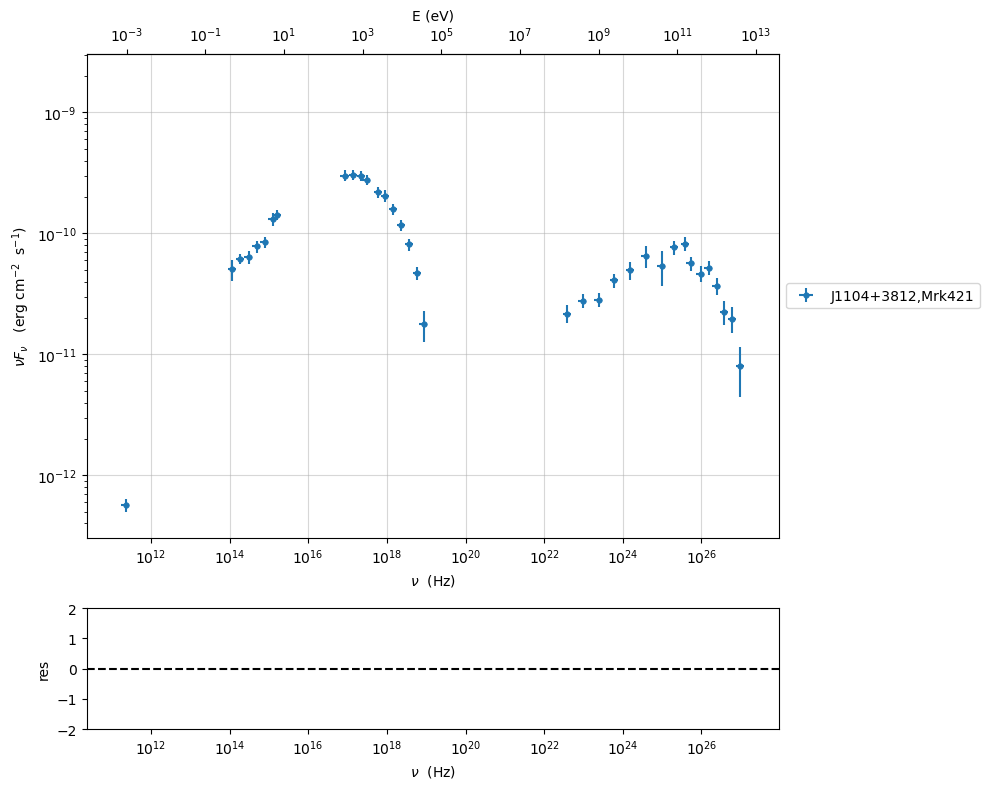

In [68]:
sed_data=ObsData(data_table=data)
sed_data.group_data(bin_width=0.2)

sed_data.add_systematics(0.1,[10.**6,10.**29])
p=sed_data.plot_sed()


*** evaluating spectral indices for data ***



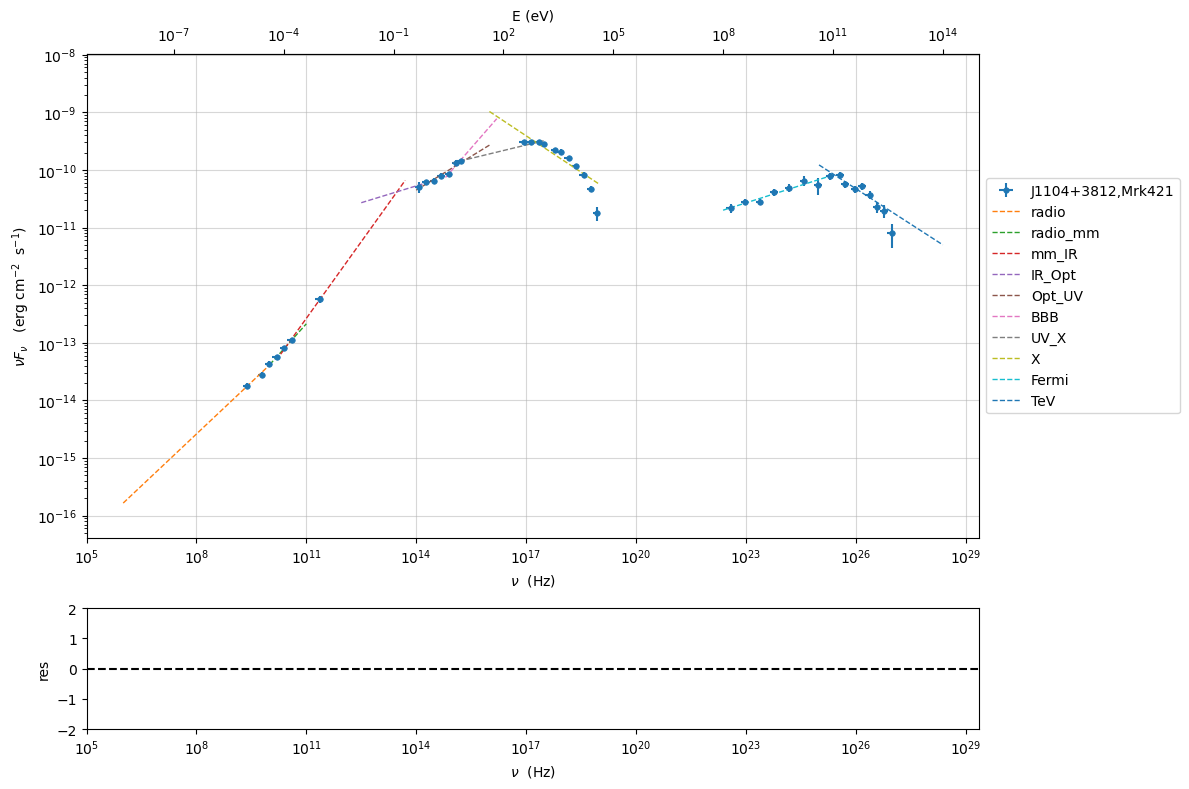

In [69]:
from jetset.sed_shaper import  SEDShape
my_shape=SEDShape(sed_data)
my_shape.eval_indices(minimizer='lsb',silent=True)
p=my_shape.plot_indices()


In [70]:
mm,best_fit=my_shape.sync_fit(check_host_gal_template=False,
                  Ep_start=None,
                  minimizer='lsb',
                  silent=True,
                  fit_range=[10.,21.])


*** Log-Polynomial fitting of the synchrotron component ***
---> first blind fit run,  fit range: [10.0, 21.0]
---> class:  HSP





model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogCubic,b,-1.585748e-01,-1.585748e-01,6.470535e-03,--,-1.000000e+00,-1.000000e+01,0.000000e+00,False
LogCubic,c,-1.089513e-02,-1.089513e-02,9.764985e-04,--,-1.000000e+00,-1.000000e+01,1.000000e+01,False
LogCubic,Ep,1.673177e+01,1.673177e+01,2.478677e-02,--,1.667298e+01,0.000000e+00,3.000000e+01,False
LogCubic,Sp,-9.489417e+00,-9.489417e+00,1.853260e-02,--,-1.000000e+01,-3.000000e+01,0.000000e+00,False


---> sync       nu_p=+1.673177e+01 (err=+2.478677e-02)  nuFnu_p=-9.489417e+00 (err=+1.853260e-02) curv.=-1.585748e-01 (err=+6.470535e-03)




*** Log-Polynomial fitting of the IC component ***
---> fit range: [23.0, 29.0]
---> LogCubic fit
====> simplex
====> migrad
====> simplex
====> migrad
====> simplex
====> migrad




model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogCubic,b,-1.971111e-01,-1.971111e-01,2.679732e-02,--,-1.000000e+00,-1.000000e+01,0.000000e+00,False
LogCubic,c,-4.037544e-02,-4.037544e-02,2.119803e-02,--,-1.000000e+00,-1.000000e+01,1.000000e+01,False
LogCubic,Ep,2.521789e+01,2.521789e+01,1.198160e-01,--,2.529262e+01,0.000000e+00,3.000000e+01,False
LogCubic,Sp,-1.012535e+01,-1.012535e+01,2.996508e-02,--,-1.000000e+01,-3.000000e+01,0.000000e+00,False


---> IC         nu_p=+2.521789e+01 (err=+1.198160e-01)  nuFnu_p=-1.012535e+01 (err=+2.996508e-02) curv.=-1.971111e-01 (err=+2.679732e-02)



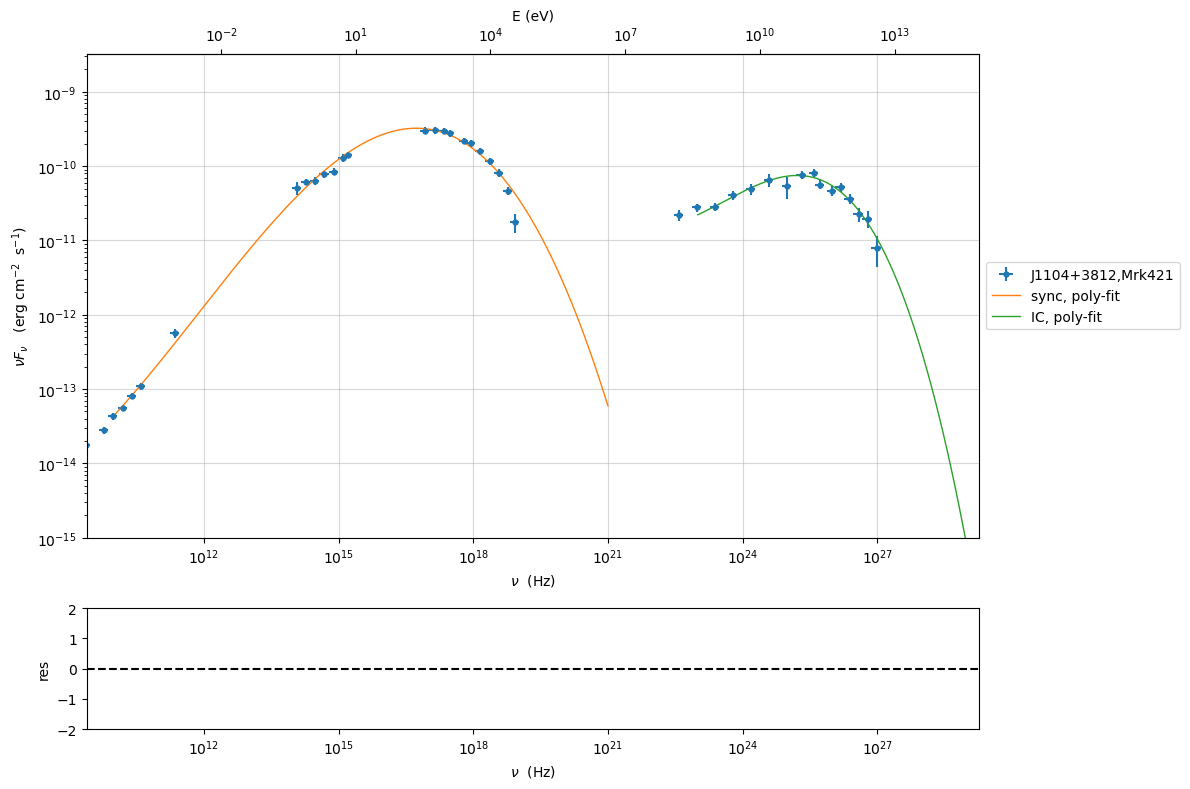

In [71]:
my_shape.IC_fit(fit_range=[23.,29.],minimizer='minuit',silent=True)
p=my_shape.plot_shape_fit()
p.setlim(y_min=1E-15)

In [72]:
from jetset.obs_constrain import ObsConstrain
from jetset.model_manager import  FitModel
sed_obspar=ObsConstrain(beaming=25,
                        B_range=[0.001,0.1],
                        distr_e='lppl',
                        t_var_sec=3*86400,
                        nu_cut_IR=1E12,
                        SEDShape=my_shape)


prefit_jet=sed_obspar.constrain_SSC_model(electron_distribution_log_values=False,silent=True)
prefit_jet.save_model('prefit_jet.pkl')


***  constrains parameters from observable ***

===> setting C threads to 12


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,3.460321e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e+00,0.000000e+00,--,False,True
jet_leptonic,beam_obj,beaming,,2.500000e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,3.080000e-02,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.697542e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.373160e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,6.545152e-01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,3.333017e+04,1.000000e+00,1.000000e+09,False,False


In [73]:
from jetset.minimizer import fit_SED,ModelMinimizer

from jetset.model_manager import  FitModel
from jetset.jet_model import Jet
prefit_jet=Jet.load_model('prefit_jet.pkl')

===> setting C threads to 12


In [74]:
fit_model=FitModel( jet=prefit_jet, name='SSC-best-fit-lsb',template=None)
fit_model.parameters

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.697542e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.373160e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,6.545152e-01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,3.333017e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.183468e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,7.928739e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,3.460321e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e+00,0.000000e+00,--,False,True


None

In [75]:
fit_model.jet_leptonic.parameters.beam_obj.fit_range = [5, 50]
fit_model.jet_leptonic.parameters.R_H.val=5E17
fit_model.jet_leptonic.parameters.R_H.frozen=False
fit_model.jet_leptonic.parameters.R_H.fit_range = [1E15, 1E19]
fit_model.jet_leptonic.parameters.R.fit_range = [10 ** 15.5, 10 ** 17.5]
fit_model.jet_leptonic.parameters.gamma0_log_parab.fit_range = [1E3,1E6]
fit_model.jet_leptonic.parameters.gmin.fit_range = [10,1000]
fit_model.jet_leptonic.parameters.gmax.fit_range = [1E5,1E8]

fit_model.jet_leptonic.add_user_par(name='B0',units='G',val=1E3,val_min=0,val_max=None)
fit_model.jet_leptonic.add_user_par(name='R0', units='cm', val=5E13, val_min=0, val_max=None)
fit_model.jet_leptonic.add_user_par(name='m_B', val=1, val_min=1, val_max=2)
fit_model.jet_leptonic.parameters.R0.frozen=True
fit_model.jet_leptonic.parameters.B0.frozen=True

def par_func(R0,B0,R_H,m_B): 
    return B0*np.power((R0/R_H),m_B)

fit_model.jet_leptonic.make_dependent_par(par='B', depends_on=['B0', 'R0', 'R_H','m_B'], par_expr=par_func)
fit_model.parameters

adding par: B0 to  B
adding par: R0 to  B
adding par: R_H to  B
adding par: m_B to  B
==> par B is depending on ['B0', 'R0', 'R_H', 'm_B'] according to expr:   B =
def par_func(R0,B0,R_H,m_B): 
    return B0*np.power((R0/R_H),m_B)



model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.697542e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.373160e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,6.545152e-01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,3.333017e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.183468e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,7.928739e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,3.460321e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H(M),region_position,cm,5.000000e+17,0.000000e+00,--,False,False
jet_leptonic,"*B(D,m_B)",magnetic_field,gauss,1.000000e-01,0.000000e+00,--,False,True
jet_leptonic,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e+00,0.000000e+00,--,False,True


None

Text(0, 0.5, 'B (G)')

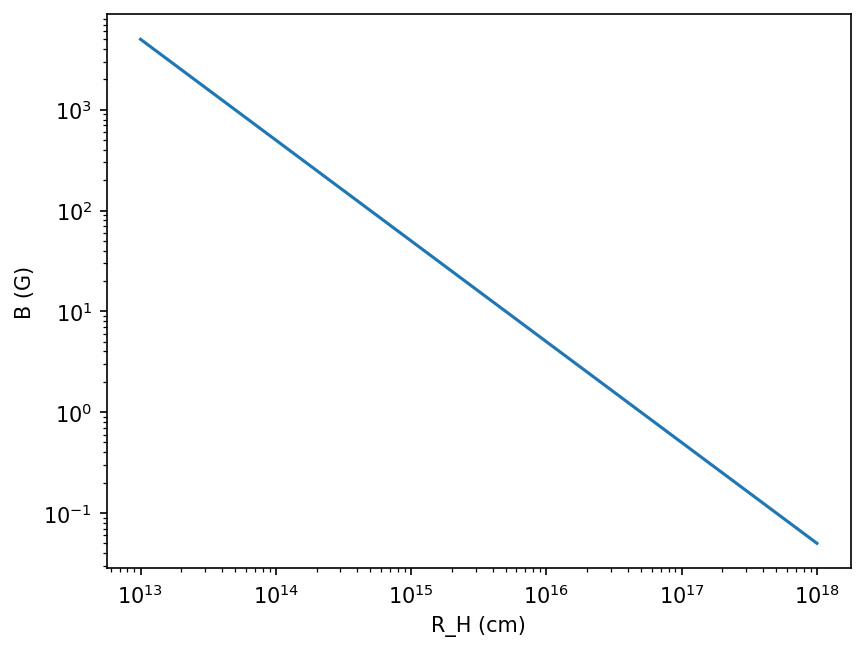

In [76]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(dpi=150)
R_H_array=np.logspace(13,18,100)
B_array=np.zeros(R_H_array.shape)
for ID,R_H in enumerate(R_H_array):
    fit_model_lsb.jet_leptonic.parameters.R_H.val=R_H
    B_array[ID]=fit_model_lsb.jet_leptonic.parameters.B.val

plt.loglog(R_H_array,B_array)
plt.xlabel('R_H (cm)')
plt.ylabel('B (G)')

In [77]:
fit_model.jet_leptonic.parameters.R_H.val=5E17

In [78]:
fit_model.parameters

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.697542e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.373160e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,6.545152e-01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,3.333017e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.183468e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,7.928739e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,3.460321e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H(M),region_position,cm,5.000000e+17,0.000000e+00,--,False,False
jet_leptonic,"*B(D,m_B)",magnetic_field,gauss,1.000000e-01,0.000000e+00,--,False,True
jet_leptonic,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e+00,0.000000e+00,--,False,True


None

As a resuslt of the best fit modeling, we are able to determine the value of `R_H`. We now perform the fit with minuit to get a better estimate of the errors

In [79]:
model_minimizer_minuit=ModelMinimizer('minuit')

In [80]:
model_minimizer_minuit.minimizer.add_simplex=False

In [81]:
best_fit_minuit=model_minimizer_minuit.fit(fit_model,
                                     sed_data,
                                     1E11,
                                     1E29,
                                     fitname='SSC-best-fit-minuit',
                                     repeat=3)

filtering data in fit range = [1.000000e+11,1.000000e+29]
data length 35

*** start fit process ***
----- 
fit run: 0


0it [00:00, ?it/s]

====> migrad
- best chisq=3.30494e+01

fit run: 1
- old chisq=3.30494e+01


0it [00:00, ?it/s]

====> migrad
- best chisq=2.21161e+01

fit run: 2
- old chisq=2.21161e+01


0it [00:00, ?it/s]

====> migrad
- best chisq=2.01970e+01

-------------------------------------------------------------------------
Fit report

Model: SSC-best-fit-minuit


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,5.955908e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,7.336491e+05,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,7.078650e-01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,3.225336e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.232280e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,6.488585e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,2.940961e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H(M),region_position,cm,4.786191e+17,0.000000e+00,--,False,False
jet_leptonic,"*B(D,m_B)",magnetic_field,gauss,4.766679e-02,0.000000e+00,--,False,True
jet_leptonic,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e+00,0.000000e+00,--,False,True



converged=True
calls=4803
mesg=


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 20.2                       │             Nfcn = 4803              │
│ EDM = 3.32e-07 (Goal: 0.0002)    │           time = 102.1 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_0  │   595.6   │    1.1    │            │            │   10    │  1000   │       │
│ 1 │ par_1  │  733.6e3  │   0.5e3   │            │            │ 100000  │  1e+08  │       │
│ 2 │ par_2  │707.865e-3 │ 0.010e-3  │            │            │    0    │         │       │
│ 3 │ par_3  │ 32.2534e3 │ 0.0022e3  │            │            │  1000   │  1e+06  │       │
│ 4 │ par_4  │ 2.232280  │ 0.000023  │            │            │   -10   │   10    │       │
│ 5 │ par_5  │ 648.86e-3 │  0.26e-3  │            │            │   -15   │   15    │       │
│ 6 │ par_6  │29.4096e15 │ 0.0012e15 │            │            │3.16228e+15│3.16228e+17│       │
│ 7 │ par_7  │478.619e15 │ 0.027e15  │            │            │  1e+15  │  1e+19  │       │
│ 8 │ par_8  │ 37.26640  │  0.00024  │            │            │    5    │   50    │       │
│ 9 │ par_9  │57.9902e-3 │ 0.0034e-3 │            │            │    0    │         │       │
│ 10│ par_10 │ 1.0855972 │ 0.0000033 │            │            │    1    │    2    │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

dof=24
chisq=20.196967, chisq/red=0.841540 null hypothesis sig=0.685522

best fit pars


model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
jet_leptonic,gmin,5.955908e+02,5.955908e+02,1.099191e+00,--,4.697542e+02,1.000000e+01,1.000000e+03,False
jet_leptonic,gmax,7.336491e+05,7.336491e+05,5.239237e+02,--,1.373160e+06,1.000000e+05,1.000000e+08,False
jet_leptonic,N,7.078650e-01,7.078650e-01,1.030217e-05,--,6.545152e-01,0.000000e+00,--,False
jet_leptonic,gamma0_log_parab,3.225336e+04,3.225336e+04,2.156816e+00,--,3.333017e+04,1.000000e+03,1.000000e+06,False
jet_leptonic,s,2.232280e+00,2.232280e+00,2.282556e-05,--,2.183468e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,r,6.488585e-01,6.488585e-01,2.582949e-04,--,7.928739e-01,-1.500000e+01,1.500000e+01,False
jet_leptonic,R,2.940961e+16,2.940961e+16,1.250211e+12,--,3.460321e+16,3.162278e+15,3.162278e+17,False
jet_leptonic,R_H(M),4.786191e+17,4.786191e+17,2.668558e+13,--,5.000000e+17,1.000000e+15,1.000000e+19,False
jet_leptonic,"*B(D,m_B)",4.766679e-02,--,--,--,1.000000e-01,0.000000e+00,--,True
jet_leptonic,NH_cold_to_rel_e,1.000000e+00,--,--,--,1.000000e+00,0.000000e+00,--,True


-------------------------------------------------------------------------




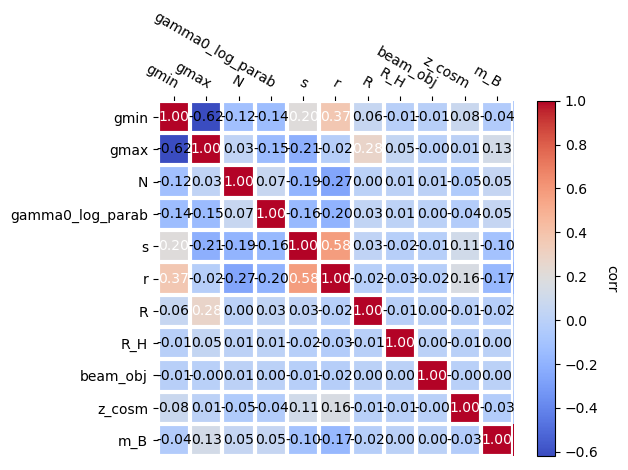

In [84]:
p=model_minimizer_minuit.plot_corr_matrix()

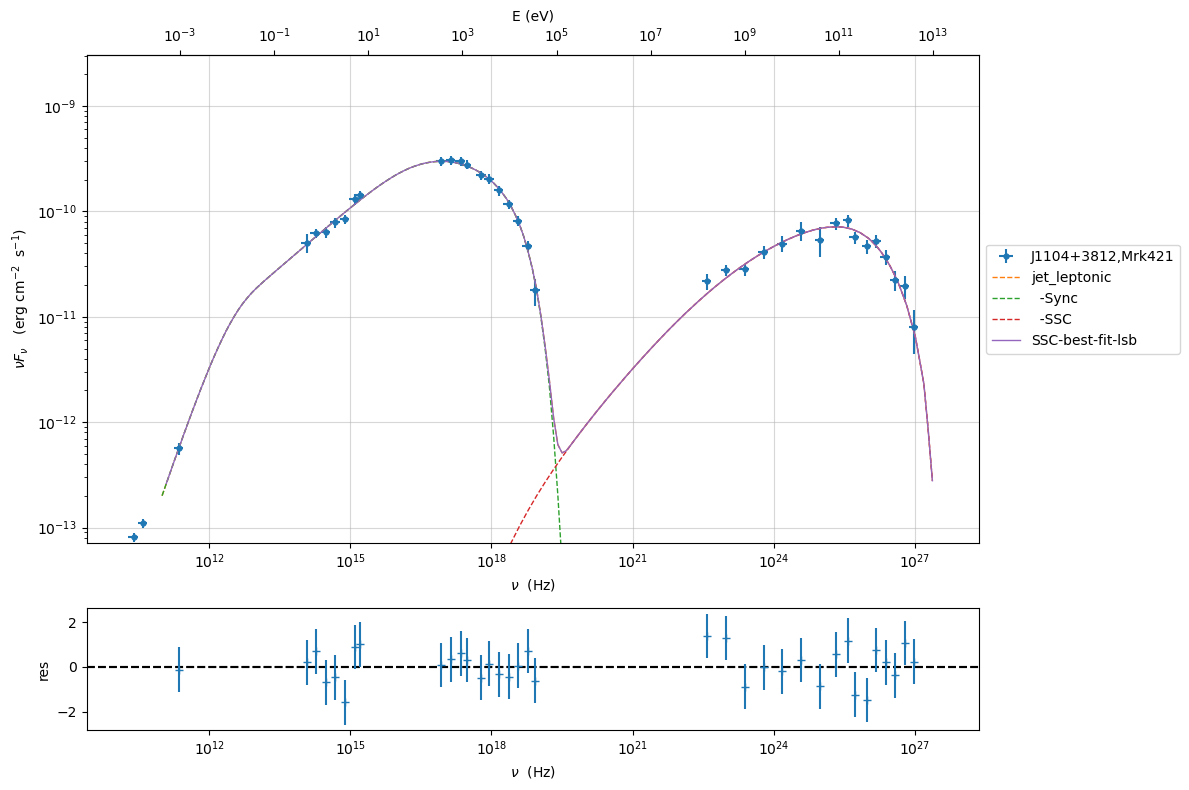

In [82]:
fit_model.plot_model(sed_data=sed_data)

In [ ]:
%matplotlib inline
plt.figure(dpi=150)
R_H_array=np.logspace(13,18,100)
B_array=np.zeros(R_H_array.shape)
for ID,R_H in enumerate(R_H_array):
    fit_model_lsb.jet_leptonic.parameters.R_H.val=R_H
    B_array[ID]=fit_model_lsb.jet_leptonic.parameters.B.val

plt.loglog(R_H_array,B_array)
plt.xlabel('R_H (cm)')
plt.ylabel('B (G)')

In [ ]:
fit_model.save_model('test.pkl')


In [ ]:
from jetset.model_manager import  FitModel

new_fit_model=FitModel.load_model('test.pkl')

In [ ]:
new_fit_model.parameters

In [ ]:
new_fit_model.jet_leptonic.parameters.reset_dependencies()

In [ ]:
new_fit_model.parameters